# PLN

| Column          | Description                                       |
|-----------------|---------------------------------------------------|
| label           | Classe pertencente: Sarcasmo ou Não               |
| comment         | Texto do comentário                               |
| author          | Autor do comentário                               |
| subreddit       | Assunto comentado                                 |
| score           | Diferença entre votos positivos e negativos      |
| date            | Data do comentário                                |
| parent_comment  | Comentário de origem                              |valor |   |

#Imports

In [2]:
import string
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition   import PCA
from nltk.corpus             import stopwords
from nltk.stem               import PorterStemmer
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn                 import model_selection, naive_bayes
from sklearn                 import svm
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

## Helper Functions

In [3]:
# Função para formatar notação científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Tamanho dos Graficos
sns.set(style = "darkgrid")
sns.set(rc={"figure.figsize":(15, 10)})

## Load Data

In [4]:
cmt_0 = pd.read_csv('C:/Users/PC/projetos/PUC/preprocessamento/COMENTARIOS_0.csv', delimiter=',')
cmt_1 = pd.read_csv('C:/Users/PC/projetos/PUC/preprocessamento/COMENTARIOS_1.csv', delimiter=',')

In [5]:
cmt_1.shape

(505413, 7)

## Concatenar os dados

In [6]:
cmt = pd.concat([cmt_0, cmt_1], axis=0)

In [7]:
cmt.head()

,label,comment,author,subreddit,score,date,parent_comment
0,0,NC and NH.,Trumpbart,politics,2.00,2016-10,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4.00,2016-11,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3.00,2016-09,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8.00,2016-10,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6.00,2016-12,Yep can confirm I saw the tool they use for th...


# Data Description

In [8]:
df1 = cmt.copy()

## Data Dimension

In [9]:
print(f'Number of Columns: {df1.shape[1]}\n')
print(f'Number of Rows: {df1.shape[0]}')


Number of Columns: 7

Number of Rows: 1010826


## Data types

In [10]:
df1.dtypes

label               int64
comment            object
author             object
subreddit          object
score             float64
date               object
parent_comment     object
dtype: object

## Check NA

In [11]:
df1.isna().sum()

label              0
comment           55
author             0
subreddit          3
score              4
date               0
parent_comment     0
dtype: int64

## Drop NA

Os valores NA não são muitos. Nesse primeiro ciclo a decisão é de excluir.

In [12]:
df1.dropna(inplace=True)

## Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [14]:
#central tendency - mean, median, 
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()) ).T

#Merge
n = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
n.columns = ['attributes', 'min', 'max', 'range','mean', 'median', 'std','skew','kurtosis']
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,label,0.00,1.00,1.00,0.50,0.00,0.50,0.00,-2.00
1,score,-507.00,9999999.00,10000506.00,17.77,2.00,9996.32,991.43,990900.86


## Check data balance

label
0   0.50
1   0.50
Name: count, dtype: float64


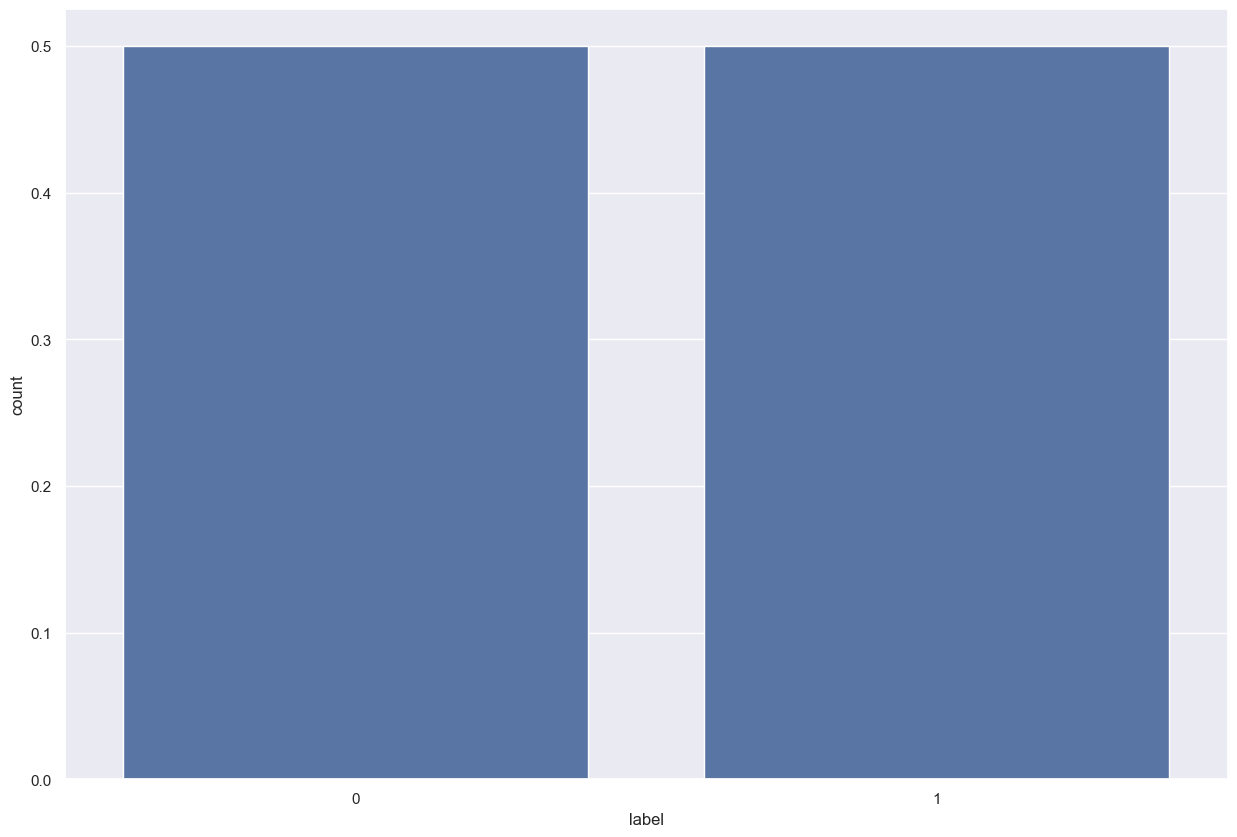

In [15]:
print(df1['label'].value_counts()/ len(df1))
sns.barplot(df1['label'].value_counts()/ len(df1));

# Tratamento dos Dados

In [16]:
df2 = df1.copy()

## Check Outliers

verificar e tratar outliers é uma prática essencial para garantir a qualidade dos dados, a precisão das análises estatísticas e a robustez dos modelos, contribuindo para uma interpretação mais confiável e precisa dos dados.

### Tratamento de Outliers - Usando Média

In [17]:
df2['score'] = np.where(df2['score'] >= df2['score'].quantile(0.9998),
                       df2[( df2['score'] > df2['score'].quantile(0.0002)) &
                            (df2['score'] < df2['score'].quantile(0.9998))]['score'].mean(),
                            df2['score'])
                         
print('Média score: ', df2['score'].mean() )
                        

Média score:  6.406366582530469


# Feature engineering

In [19]:
df3 = df2.copy()

In [20]:
# criar coluna com a quantidade de palavras contidas na coluna comment
df3['comment_wcount'] = df3['comment'].str.split().str.len()



In [21]:
# criar coluna com a quantidade de palavras contidas na coluna parent
df3['parent_comment_wcountt'] = df3['parent_comment'].str.split().str.len() 

In [22]:
# Converter para string
df3['comment'] = df3['comment'].astype(str)
df3['parent_comment_wcountt'] = df3['parent_comment'].astype(str) 

#Criar as varoáveis para armazenar a quantidade de caracteres da coluna comment
df3['comment_char'] = df3['comment'].apply(len)

#Criar as varoáveis para armazenar a quantidade de caracteres da coluna parent_comment
df3['parent_comment_char'] = df3['parent_comment'].apply(len) 

In [23]:
df3.head()

,label,comment,author,subreddit,score,date,parent_comment,comment_wcount,parent_comment_wcountt,comment_char,parent_comment_char
0,0,NC and NH.,Trumpbart,politics,2.00,2016-10,"Yeah, I get that argument. At this point, I'd ...",3,"Yeah, I get that argument. At this point, I'd ...",10,80
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4.00,2016-11,The blazers and Mavericks (The wests 5 and 6 s...,14,The blazers and Mavericks (The wests 5 and 6 s...,74,134
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3.00,2016-09,They're favored to win.,19,They're favored to win.,121,23
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8.00,2016-10,deadass don't kill my buzz,12,deadass don't kill my buzz,60,26
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6.00,2016-12,Yep can confirm I saw the tool they use for th...,7,Yep can confirm I saw the tool they use for th...,31,85


# Data Analysis

In [24]:
df4 = df3.copy()

## 1. Qual o percentual de cada classe de comentários

In [25]:
percentuais = pd.DataFrame()
percentuais['qtd'] =  df4.groupby('label')['label'].count()
percentuais['%'] = round((percentuais['qtd'] / percentuais['qtd'].sum())*100)

In [26]:
percentuais

,qtd,%
label,,
0,505396,50.00
1,505368,50.00


## Qual autor comenta com mais sarcasmo?

In [27]:
df4[df4['label'] ==1].groupby('author')['author'].count().nlargest()

author
Biffingston       422
pokemon_fetish    216
NeonDisease       211
ShyBiDude89       202
ivsciguy          171
Name: author, dtype: int64

## Percentualmente, ao longo do tempo os comentários sarcastico tem aumentado? Plote o gráfico.
**Pelo gráfico, nota-se claramente que houve uma queda na quantidade de comentários sarcástico.**

In [28]:
# Criar o percentual por mês
percentual_mes = pd.DataFrame()
percentual_mes['qtd'] =  df4.groupby('date')['date'].count()
percentual_mes['qtd_sarc'] = df4[df4['label']==1].groupby('date')['label'].count()
percentual_mes['%'] = round((percentual_mes['qtd_sarc'] / percentual_mes['qtd'])*100)
percentual_mes.head()

,qtd,qtd_sarc,%
date,,,
2009-01,104,72,69.00
2009-02,89,57,64.00
2009-03,105,70,67.00
2009-04,122,71,58.00
2009-05,110,68,62.00


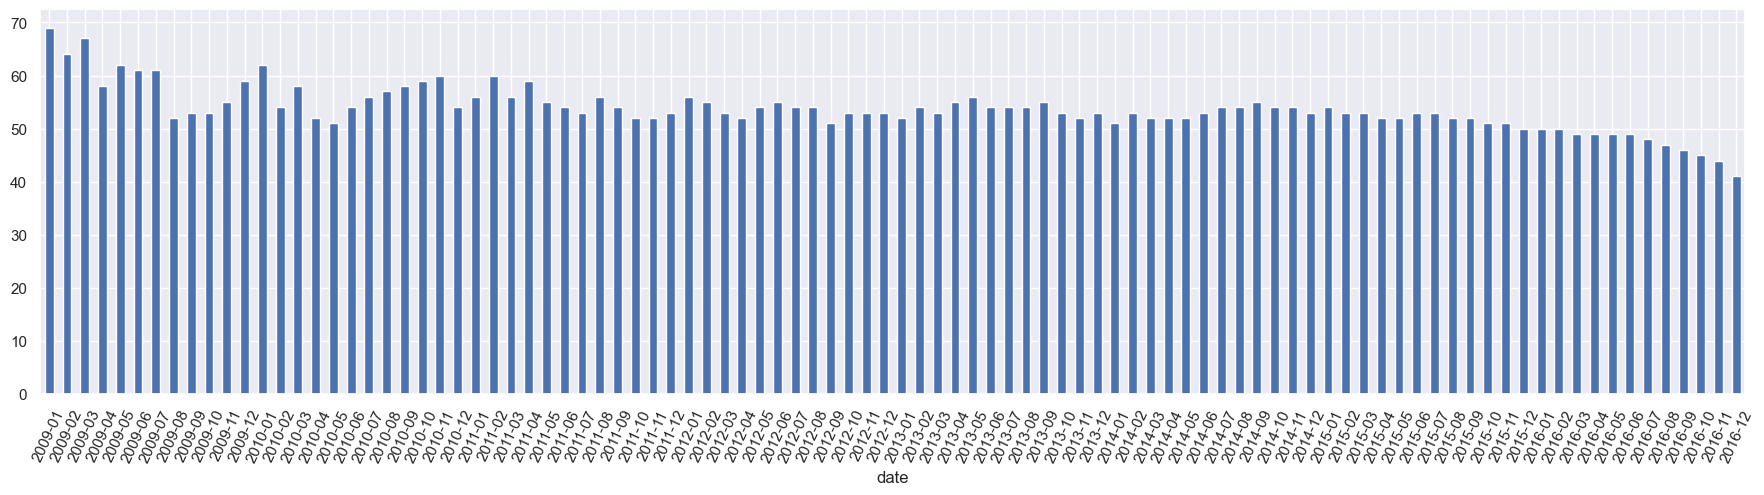

In [29]:
plt.figure(figsize=(22,5))
percentual_mes['%'].plot.bar()
plt.xticks(rotation = 65);

## Percentualmente, olhando a variável subreddit, qual assunto que mais gera comentários sarcásticos? Considerar apenas assuntos com mais de 1000 comentarios

In [30]:
percentual_subreddit = pd.DataFrame()
percentual_subreddit['qtd'] = df4.groupby('subreddit')['subreddit'].count()
percentual_subreddit['qtd_sarc'] = df4[df4['label']==1].groupby('subreddit')['subreddit'].count()
percentual_subreddit['%'] = (percentual_subreddit['qtd_sarc'] / percentual_subreddit['qtd'])*100
percentual_subreddit[percentual_subreddit['qtd'] > 1000].sort_values('%', ascending = False)

,qtd,qtd_sarc,%
subreddit,,,
creepyPMs,5466,4287.00,78.43
MensRights,3355,2284.00,68.08
ShitRedditSays,1284,850.00,66.20
worldnews,26375,16947.00,64.25
Libertarian,2562,1640.00,64.01
...,...,...,...
BlackPeopleTwitter,1831,695.00,37.96
science,1126,425.00,37.74
aww,2493,787.00,31.57


## Por tipo de comentário, quantas palavras em média tem em comment_wcount e parent_comment_wcount?

In [31]:
#df4.groupby('label')[['comment_wcount', 'parent_comment_wcountt']].mean()

## Comentários Sarcásticos são maiores ou menores que os demais? Demonstre com gráfico

C:\Users\PC\AppData\Local\Temp\ipykernel_1232\862373539.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['label']==0]['comment_char'], shade=True, label='normal', color='green', clip= (0,300));
C:\Users\PC\AppData\Local\Temp\ipykernel_1232\862373539.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['label']==1]['comment_char'], shade=True, label='sarcasmo', color='red', clip= (0,300));


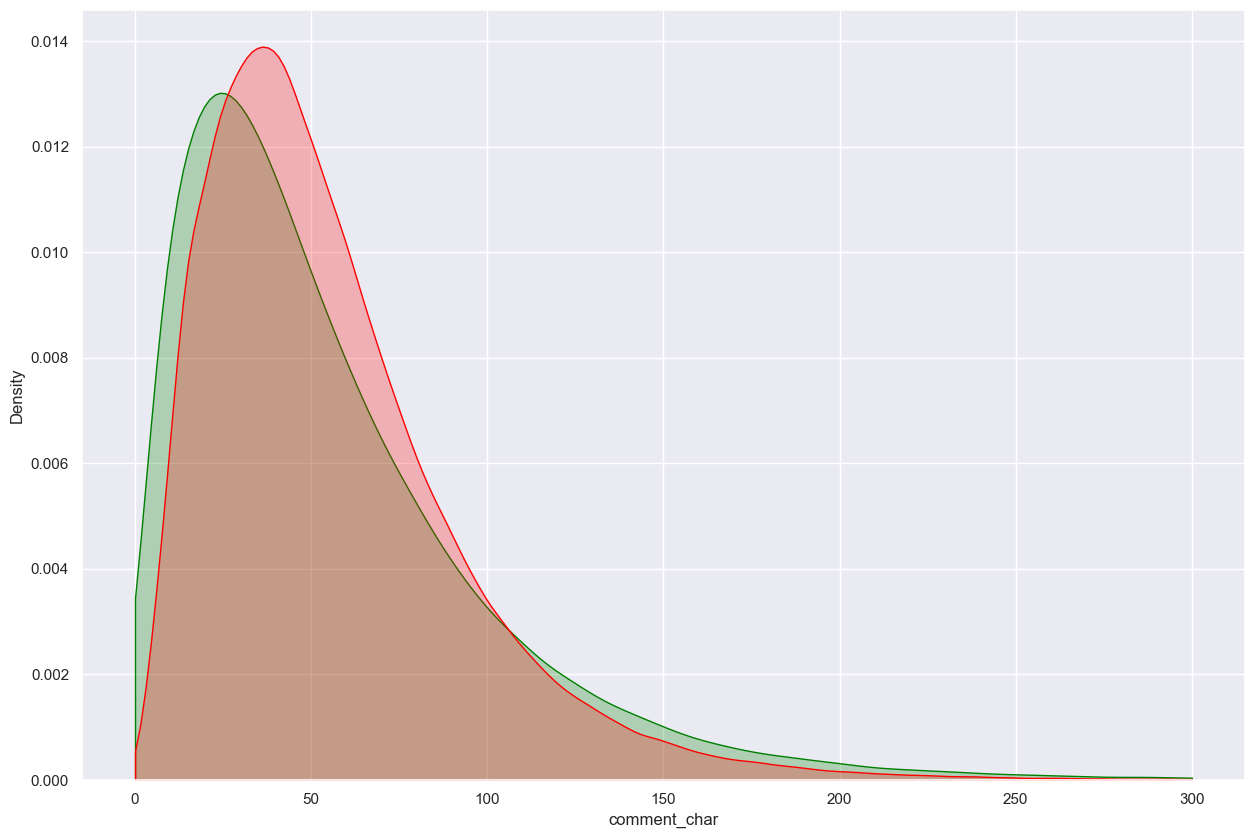

In [32]:
sns.kdeplot(df4[df4['label']==0]['comment_char'], shade=True, label='normal', color='green', clip= (0,300));
sns.kdeplot(df4[df4['label']==1]['comment_char'], shade=True, label='sarcasmo', color='red', clip= (0,300));

É possível notar que os comentários onde há sarcasmo as pessoas usam mais caracteres.

## Compare a média percentual do comment com o parent_comment.

In [33]:
(df4['comment_char'] /  (df4['comment_char'] + df4['parent_comment_char'])*100).mean()

38.421102397389355

# Preprocessamento para mineração de textos

In [96]:
# Utilizar técnicas de sample para diminuir os dados
df5 = df4.sample(frac=0.008, replace=True, random_state=42).copy()
df5.reset_index(inplace=True, drop=True)

In [97]:
df5.shape

(8086, 11)

## Remove StopWords

In [98]:
## Função para remocção das stopwords
def stop_words_remove(msg):
    sempont = [char for char in msg if char not in string.punctuation]
    
    sempont =  ''.join(sempont)
    remStWords = [word for word in sempont.split() if word.lower()
                        not in stopwords.words('english')]
    st =  PorterStemmer()
    return [st.stem(stword) for stword in remStWords]

## Vectorizer - Word Count (WC)

In [99]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [100]:
vectorizerWC = CountVectorizer(analyzer= stop_words_remove).fit(df5['comment'])
msVetWC = vectorizerWC.transform(df5['comment'])
msVetWC.shape

(8086, 9472)

In [101]:
# Transformar em Dataframe
df_msVetWC = pd.DataFrame(msVetWC.todense(), columns=vectorizerWC.get_feature_names_out())
                                      

In [102]:
msWC = pd.concat([df5['label'], df_msVetWC], axis=1)
msWC.head()   

,label,0,000,010,03,0500,0607,07,08,1,...,zombuck,zone,zoolock,zoom,zooma,zouma,zubat,zucht,zusammenfassung,zwei
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Vectorizer -TFIDF

In [103]:
vectorizerTfidf =  TfidfTransformer().fit(msVetWC)
msvetdfidf = vectorizerTfidf.transform(msVetWC)
msvetdfidf.shape

(8086, 9472)

In [78]:
# Transformar em Dataframe
df_msVetTfidf = pd.DataFrame(msvetdfidf.todense(), columns=vectorizerWC.get_feature_names_out())
msTfidf = pd.concat([df5['label'], df_msVetTfidf], axis=1)
msTfidf.head()

,label,0,000,010,03,0500,0607,07,08,1,...,zombuck,zone,zoolock,zoom,zooma,zouma,zubat,zucht,zusammenfassung,zwei
0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Qual é o top 10 palavras com valor TF-IDF (Em relação a todo corpus)

In [79]:
top10 = pd.DataFrame(vectorizerTfidf.idf_, index= vectorizerWC.get_feature_names_out(), columns = ['TF-IDF'])
top10.sort_values(by= ['TF-IDF'], ascending=False).head(10)


,TF-IDF
kote,9.30
molest,9.30
monthdayyear,9.30
mont,9.30
monsta,9.30
monocl,9.30
monk,9.30
mongol,9.30
monger,9.30
monday,9.30


## Text Mining

# Escolher dois algoritmos de classificação  

In [80]:
# Criar função performance dos modelos
def performance(model_name, y_val, y_pred):
    #calcular as métricas
    accuracy = accuracy_score(y_val, y_pred)
    precision =precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    #criar o dataframe

    return pd.DataFrame({'Modelo': model_name,
                         'Accuracy': [accuracy],
                         'Precision': [precision],
                         'Recall': [recall],
                         'F1_score': [f1]
    },index=[0])

In [94]:
## Separando os dados em treino teste
train_X_WC, test_X_WC, train_y_WC, test_y_WC = model_selection.train_test_split(msWC, df5.label.values, test_size=0.3)
# Separando os dados em treino teste
train_X_TFIDF, test_X_TFIDF, train_y_TFIDF, test_y_TFIDF = model_selection.train_test_split(msTfidf, df5.label.values, test_size=0.3)

## Naive Bayes

In [83]:
# Model Selection
nb = naive_bayes.MultinomialNB()

#Model fit
nb.fit(train_X_WC,train_y_WC)

#Model predict
yhat_nb_wc = nb.predict(test_X_WC)



In [84]:
nbwc_reuslt = performance('Naive Bayes - WC',yhat_nb_wc, test_y_WC)

,Modelo,Accuracy,Precision,Recall,F1_score
0,Naive Bayes - WC,0.87,1.00,0.79,0.89


In [85]:
# Model Selection
nb = naive_bayes.MultinomialNB()

#Model fit
nb.fit(train_X_TFIDF,train_y_TFIDF)

#Model predict
yhat_nb_TFIDF = nb.predict(test_X_TFIDF)

In [142]:
nb_tfidf_result = performance('Naive Bayes - TF-IDF ',yhat_nb_TFIDF, test_y_TFIDF )

In [143]:
nb_tfidf_result

,Modelo,Accuracy,Precision,Recall,F1_score
0,Naive Bayes - TF-IDF,0.89,1.00,0.82,0.90


## SVM

In [89]:
# Model Selection
svmtfidf = svm.SVC(C=2.0, kernel='linear', degree=3, gamma ='auto')

#Model fit
svmtfidf.fit(train_X_TFIDF,train_y_TFIDF)

#Model predict
yhat_svm_TFIDF = svmtfidf.predict(test_X_TFIDF)


In [90]:
svm_TFIDF_result = performance('SVM - TF-IDF ',yhat_svm_TFIDF, test_y_TFIDF)
svm_TFIDF_result

,Modelo,Accuracy,Precision,Recall,F1_score
0,SVM - TF-IDF,1.00,1.00,1.00,1.00


In [91]:
# Model Selection
svmwc = svm.SVC(C=1.0, kernel='linear', degree=5, gamma ='auto')

#Model fit
svmwc.fit(train_X_WC,train_y_WC)

#Model predict
yhat_svm_WC = svmwc.predict(test_X_WC)

In [92]:
svmwc_result = performance('SVM - WC', yhat_svm_WC, test_y_WC )

In [93]:
svmwc_result 

,Modelo,Accuracy,Precision,Recall,F1_score
0,SVM - WC,1.00,1.00,1.00,1.00


# Redução de dimensionalidade - PCA

In [111]:
df_pca = msWC.copy()

In [114]:
# Padronizar os dados (é importante para o PCA)
scaler = StandardScaler()
all_X_WC_standardized = scaler.fit_transform(df_pca)

# Aplicar PCA
num_components = 10  # Número desejado de componentes principais
pca = PCA(n_components=num_components)
all_X_WC_pca = pca.fit_transform(all_X_WC_standardized)

# Dividir novamente os dados de treino e teste
train_X_WC_pca, test_X_WC_pca, train_y_WC, test_y_WC = train_test_split(
    all_X_WC_pca, np.concatenate((train_y_WC, test_y_WC), axis=0), test_size=0.2, random_state=42)

## SVM

In [125]:
# Model Selection
svmwc_pca = svm.SVC(kernel='linear', C=1.0, degree=5, gamma ='auto',random_state=42)

#Model fit
svmwc_pca.fit(train_X_WC_pca, train_y_WC)

#Model predict
yhat_svm_WC_pca = svmwc_pca.predict(test_X_WC_pca)

In [140]:
svm_pca_result = performance('SVM - WC -PCA', yhat_svm_WC_pca, test_y_WC )

## Naive Bayes

In [127]:
from sklearn.naive_bayes import GaussianNB

In [137]:
# Model Selection
nb_pca = naive_bayes.GaussianNB()

#Model fit
nb_pca.fit(train_X_WC_pca,train_y_WC)

#Model predict
yhat_nb_wc_pca = nb_pca.predict(test_X_WC_pca)


In [139]:
nb_pca_result = performance('Naive Bayes - Gaussian - WC -PCA', yhat_nb_wc_pca, test_y_WC )

## Compare Performance

In [146]:
result = pd.concat( [nbwc_reuslt,svmwc_result , nb_tfidf_result,svm_TFIDF_result, svm_pca_result, nb_pca_result ] )
result 

,Modelo,Accuracy,Precision,Recall,F1_score
0,Naive Bayes - WC,0.87,1.00,0.79,0.89
0,SVM - WC,1.00,1.00,1.00,1.00
0,Naive Bayes - TF-IDF,0.89,1.00,0.82,0.90
0,SVM - TF-IDF,1.00,1.00,1.00,1.00
0,SVM - WC -PCA,0.51,1.00,0.51,0.68
0,Naive Bayes - Gaussian - WC -PCA,0.50,0.04,0.56,0.08
